In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix

pd.set_option('display.max_colwidth', None)


import warnings
warnings.filterwarnings('ignore')

## Import de dados

In [2]:
# Importe do dataset
df_animes = pd.read_csv('anime.csv')

df_rating = pd.read_csv('rating_complete.csv')

df_sinopse = pd.read_csv('anime_with_synopsis.csv')

## Descrição dos datasets

- df_animes: descrição dos animes de forma geral, tabela que contém score, nome, gênero, dentre outras informações gerais;

- df_rating: tabela que contém a relação das notas atribuidas por cada usuário;

- df_sinopse: tabela que contém a relação de cada anime com sua respectiva sinopse.

## Análise Exploratória de Dados (EDA)

In [3]:
# Primeiro contato com o dataset, visualizando o conteúdo e como estão distribuidas as features
df_animes.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [4]:
# Features
df_animes.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [5]:
# Verificando o tipo das features
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [6]:
# Renomeando as features e transformando tudo em minúsculo para facilitar a utilização
df_animes.rename(columns = {'MAL_ID':'anime_id'}, inplace=True)
df_animes.rename(columns = str.lower, inplace = True)
columns = ['anime_id','name','premiered', 'score','genres','type', 'episodes', 'studios','source','rating','popularity',\
          'members','completed','on-hold','dropped']
df_animes = df_animes[columns]

# Reparando a feature premiered em season e year e posteriormente dropando ela
df_animes[['season','year']] = df_animes['premiered'].str.split(' ', n=1, expand=True) \
                                .rename(columns={0:'season',1:'year'})
df_animes.drop('premiered', axis=1, inplace=True)

# Transformando a coluna year em int
df_animes['year'] = pd.to_numeric(df_animes['year'])

# Ajustando o nome da coluna que identica o anime pelo ID no dataset que contém as sinopses
df_sinopse = df_sinopse.rename(columns = {'MAL_ID':'anime_id'})

In [7]:
# Quantidade de nulos por feature
df_animes.isna().sum()

anime_id          0
name              0
score             0
genres            0
type              0
episodes          0
studios           0
source            0
rating            0
popularity        0
members           0
completed         0
on-hold           0
dropped           0
season            0
year          12817
dtype: int64

In [8]:
df_animes.head(2)

,anime_id,name,score,genres,type,episodes,studios,source,rating,popularity,members,completed,on-hold,dropped,season,year
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,Sunrise,Original,R - 17+ (violence & profanity),39,1251960,718161,71513,26678,Spring,1998.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,Bones,Original,R - 17+ (violence & profanity),518,273145,208333,1935,770,Unknown,NaN


In [9]:
df_animes['year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17562 entries, 0 to 17561
Series name: year
Non-Null Count  Dtype  
--------------  -----  
4745 non-null   float64
dtypes: float64(1)
memory usage: 137.3 KB


In [10]:
# Verificando as estatísticas básicas das features numéricas
df_animes.describe()

,anime_id,popularity,members,completed,on-hold,dropped,year
count,17562.000000,17562.000000,1.756200e+04,1.756200e+04,17562.000000,17562.000000,4745.000000
mean,21477.192347,8763.452340,3.465854e+04,2.209557e+04,955.049653,1176.599533,2006.313593
std,14900.093170,5059.327278,1.252821e+05,9.100919e+04,4275.675096,4740.348653,12.898287
min,1.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,1961.000000
25%,5953.500000,4383.500000,3.360000e+02,1.110000e+02,6.000000,37.000000,2001.000000
50%,22820.000000,8762.500000,2.065000e+03,8.175000e+02,45.000000,77.000000,2010.000000
75%,35624.750000,13145.000000,1.322325e+04,6.478000e+03,291.750000,271.000000,2016.000000
max,48492.000000,17565.000000,2.589552e+06,2.182587e+06,187919.000000,174710.000000,2021.000000


In [11]:
# Verificndo a quantidade de produções por tipo, fonte, classificação etária, temporada e Ano de lançamento
for feature in ['type','source','rating','season','year']:
    display(pd.DataFrame(df_animes['anime_id'].groupby(df_animes[feature]).count().sort_values(ascending=False)) \
            .rename(columns={'anime_id':'quantidade'}))

,quantidade
type,
TV,4996
OVA,3894
Movie,3041
Special,2218
ONA,1907
Music,1469
Unknown,37


,quantidade
source,
Original,5215
Manga,3825
Unknown,3567
Visual novel,993
Game,880
Light novel,768
Other,597
Novel,510
Music,317


,quantidade
rating,
PG-13 - Teens 13 or older,6132
G - All Ages,5782
PG - Children,1461
Rx - Hentai,1345
R - 17+ (violence & profanity),1157
R+ - Mild Nudity,997
Unknown,688


,quantidade
season,
Unknown,12817
Spring,1611
Fall,1389
Winter,942
Summer,803


,quantidade
year,
2017.0,266
2016.0,262
2018.0,257
2015.0,229
2014.0,227
...,...
1966.0,11
1963.0,5
1964.0,4


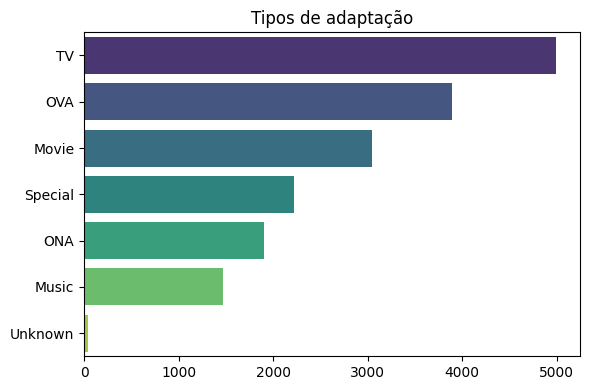

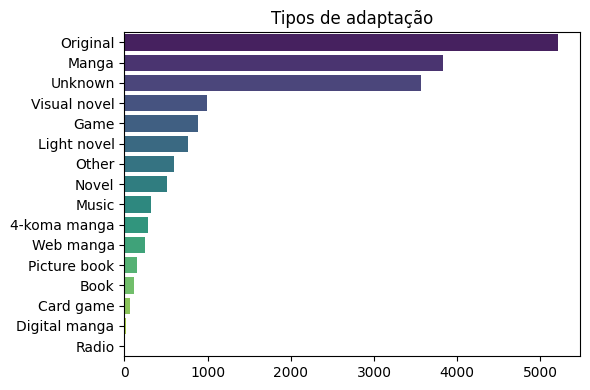

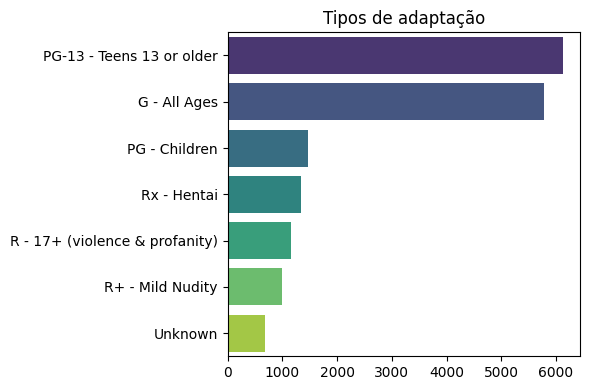

In [12]:
# Visualizando a quantidade de produções de acordo com os tipos, fontes e classificação etária 
for feature in ['type','source','rating']:
    anime_feature_count = df_animes[feature].value_counts()
    sns.barplot(x=anime_feature_count.values,
                y=anime_feature_count.index,
                palette='viridis') \
                .set_title('Tipos de adaptação')
    plt.gcf().set_size_inches(6, 4)
    plt.tight_layout()
    plt.show()

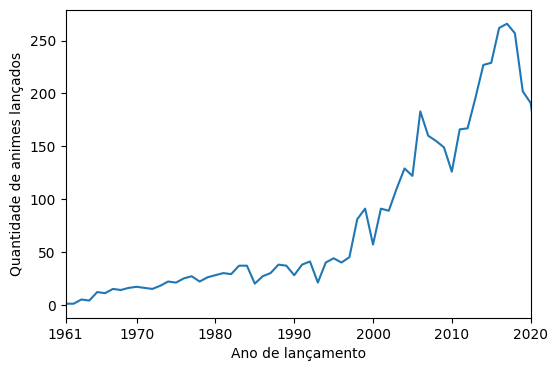

In [13]:
# Visualizando o crescimento da produção de animes
year = pd.DataFrame(df_animes['year'].groupby(df_animes['year']).count()).rename(columns={'year':'quantidade'})
sns.lineplot(data=year,
               x=year.index,
               y=year['quantidade']);

## Ajuste de tamanho do gráfico
plt.gcf().set_size_inches(6, 4)
plt.xlabel('Ano de lançamento')
plt.ylabel('Quantidade de animes lançados')
plt.xlim(1961,2020)
plt.xticks([1961, 1970, 1980, 1990, 2000, 2010, 2020]);

In [14]:
# Os 10 animes mais bem avaliados, sendo necessário haver no mínimo 700.000 membros, foram considerados todos os
# tipos de produção

df_animes[['name','score','genres','type', 'episodes', 'studios','source','rating',\
          'members']].sort_values(by='score', ascending = False).query('members > (700000)').head(10)

,name,score,genres,type,episodes,studios,source,rating,members
3971,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",TV,64,Bones,Manga,R - 17+ (violence & profanity),2248456
15926,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",TV,16,MAPPA,Manga,R - 17+ (violence & profanity),733260
5683,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,White Fox,Visual novel,PG-13 - Teens 13 or older,1771162
6474,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",TV,148,Madhouse,Manga,PG-13 - Teens 13 or older,1673924
14963,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",TV,10,Wit Studio,Manga,R - 17+ (violence & profanity),1073626
9886,Koe no Katachi,9.0,"Drama, School, Shounen",Movie,1,Kyoto Animation,Manga,PG-13 - Teens 13 or older,1387607
833,Gintama,8.96,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,201,Sunrise,Manga,PG-13 - Teens 13 or older,754607
3537,Clannad: After Story,8.96,"Slice of Life, Comedy, Supernatural, Drama, Romance",TV,24,Kyoto Animation,Visual novel,PG-13 - Teens 13 or older,915885
11308,Kimi no Na wa.,8.96,"Romance, Supernatural, School, Drama",Movie,1,CoMix Wave Films,Original,PG-13 - Teens 13 or older,1726660
2656,Code Geass: Hangyaku no Lelouch R2,8.91,"Action, Military, Sci-Fi, Super Power, Drama, Mecha",TV,25,Sunrise,Original,R - 17+ (violence & profanity),1268320


## **KNN** - Recomendação de animes

In [15]:
# Filtrando os animes de acordo com a quantidade de membros de forma a eliminar os animes com poucos membros
animes_selecionados = df_animes[['anime_id', 'name']].loc[df_animes['members'] >= 150000]

In [16]:
df_rating_selecionados = animes_selecionados.merge(df_rating, on = 'anime_id')

In [17]:
user_rating_matrix = df_rating_selecionados.pivot(index = 'name', columns = 'user_id', values = 'rating')

In [18]:
# preenchendo os valores nulos com zero, pois indicam a não avaliação de determinado anime por determinado usuário
user_rating_matrix.fillna(0, inplace = True)

In [19]:
user_rating_matrix

user_id,0,1,2,3,4,5,6,7,8,10,...,353392,353393,353395,353396,353398,353400,353401,353402,353403,353404
name,,,,,,,,,,,,,,,,,,,,,
.hack//Sign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07-Ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11eyes,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3-gatsu no Lion,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0
3-gatsu no Lion 2nd Season,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zetsuen no Tempest,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
Zoku Natsume Yuujinchou,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zombieland Saga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# transformando em uma matriz esparsa, armazenando os elementos em uma coluna esparsa comprimida
sparse_matrix = csc_matrix(user_rating_matrix)

In [21]:
# criando o modelo KNN
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(\
                         # número de vizinhos, neste caso nossas recomendações
                         n_neighbors = 6,
                         # algoritmo
                         algorithm = 'brute',
                         # tipo de distância utilizada
                         metric= 'cosine'
                         )

# ajustando o modelo
model.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [22]:
def localizar_anime(titulo, matriz):
  for anime_position, anime_titulo in enumerate(matriz.index):
    if titulo in anime_titulo:
      print(anime_position, anime_titulo)

In [23]:
def recomendacoes_animes (indice_anime, matriz, modelo):
  # selecionar o anime a ser predito
  anime = matriz.iloc[indice_anime ,:]

  # transforma a série gerada anteriormente em array com somente os valores
  anime = anime.values

  # transforma em vetor de uma linha, o parâmetro -1 indica para o numpy inferir a quantidade que for necessária na dimensão
  anime = anime.reshape(1,-1)

  distancia, recomendacao = modelo.kneighbors(anime)

  # verificando quais animes foram recomendados
  for i in range(len(recomendacao)):
    lista_animes_rec = matriz.index[recomendacao[i]].tolist()
    lista_animes_rec

  return(df_sinopse.loc[np.where(df_sinopse['Name'].isin(lista_animes_rec))])

In [24]:
# Localizando o anime escolhido no grupo de animes mais populares
localizar_anime('Deat', user_rating_matrix)

184 Death Billiards
185 Death March kara Hajimaru Isekai Kyousoukyoku
186 Death Note
187 Death Note: Rewrite
188 Death Parade
640 Neon Genesis Evangelion: Death & Rebirth


In [25]:
# inserir o valor do indice em que se encontra o anime a ser comparado na matriz de popularidade
id_recomendacao = 186

In [26]:
# Imputar o nome do anime requerido
def procura_df_animes(dataframe, coluna, termo):
    resultado = dataframe[dataframe[coluna].str.contains(termo)]
    return display(resultado)

In [27]:
procura_df_animes(df_animes, 'name', 'Deat')

,anime_id,name,score,genres,type,episodes,studios,source,rating,popularity,members,completed,on-hold,dropped,season,year
21,31,Neon Genesis Evangelion: Death & Rebirth,7.45,"Drama, Mecha, Psychological, Sci-Fi",Movie,1,"Gainax, Production I.G",Original,R - 17+ (violence & profanity),833,180681,146202,1069,961,Unknown,NaN
1175,1286,MD Geist II: Death Force,5.03,"Action, Military, Sci-Fi, Mecha",OVA,1,Zero-G Room,Original,R+ - Mild Nudity,5773,6698,5118,67,61,Unknown,NaN
1393,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen",TV,37,Madhouse,Manga,R - 17+ (violence & profanity),1,2589552,2146116,75054,80834,Fall,2006.0
2731,2994,Death Note: Rewrite,7.71,"Mystery, Police, Psychological, Supernatural, Thriller",Special,2,Madhouse,Manga,R - 17+ (violence & profanity),965,154021,103247,2699,1976,Unknown,NaN
6213,10444,Digimon Xros Wars: Aku no Death General to Nanatsu no Oukoku,7.16,"Action, Adventure, Fantasy, Comedy, Shounen",TV,24,Toei Animation,Original,PG - Children,3490,22062,16117,465,545,Spring,2011.0
7127,14353,Death Billiards,7.93,"Game, Mystery, Psychological, Drama, Thriller",Movie,1,Madhouse,Original,R - 17+ (violence & profanity),777,191518,150638,991,492,Unknown,NaN
9742,28223,Death Parade,8.2,"Game, Mystery, Psychological, Drama, Thriller",TV,12,Madhouse,Original,R - 17+ (violence & profanity),48,1213828,857277,34803,27071,Winter,2015.0
10344,30094,Majin Sentai Death Ranger: Ubawareta Pudding!,Unknown,"Action, Comedy",ONA,1,Unknown,Unknown,G - All Ages,13908,267,165,5,31,Unknown,NaN
11968,33566,Baki: Most Evil Death Row Convicts Special Anime,6.49,"Action, Martial Arts, Shounen",OVA,1,Telecom Animation Film,Manga,R - 17+ (violence & profanity),4940,9802,6133,113,149,Unknown,NaN
12453,34497,Death March kara Hajimaru Isekai Kyousoukyoku,6.54,"Adventure, Fantasy, Harem",TV,12,"SILVER LINK., Connect",Light novel,PG-13 - Teens 13 or older,411,334103,239264,4715,17246,Winter,2018.0


# Recomendação para animes underrated

In [28]:
# ID do anime a ser comparado na matriz de baixa popularidade
id_anime_comparado = 1535

In [29]:
# RECOMENDAÇÃO COM BASE EM ANIMES UNDERRATED - members entre 50.000 e 150.000. Utilizando o anime_id do anime a ser comparado
animes_underrated = df_animes[['anime_id', 'name']].loc[(df_animes['members'] <= 150000) & (df_animes['members'] >= 50000)]\
                  .append(df_animes[['anime_id','name']].loc[df_animes['anime_id'] == id_anime_comparado])

In [30]:
df_rating_underrated = animes_underrated.merge(df_rating, on = 'anime_id')

In [31]:
underrated_user_rating_matrix = df_rating_underrated.pivot(index = 'name', columns = 'user_id', values = 'rating')

In [32]:
underrated_user_rating_matrix.fillna(0, inplace = True)

In [33]:
underrated_user_rating_matrix

user_id,0,1,2,3,4,5,6,7,8,10,...,353391,353392,353395,353396,353398,353400,353401,353402,353403,353404
name,,,,,,,,,,,,,,,,,,,,,
"""Bungaku Shoujo"" Movie",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Roots,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Tasogare no Udewa Densetsu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
100-man no Inochi no Ue ni Ore wa Tatteiru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
30-sai no Hoken Taiiku,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s.CRY.ed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Kei,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# transformando em uma matriz esparsa, armazenando os elementos em uma coluna esparsa comprimida
underrated_sparse_matrix = csc_matrix(underrated_user_rating_matrix)

In [35]:
model_underrated = NearestNeighbors(\
                         # número de vizinhos, neste caso nossas recomendações
                         n_neighbors = 3,
                         # algoritmo
                         algorithm = 'brute',
                         # tipo de distância utilizada
                         metric= 'cosine'
                         )

# ajustando o modelo
model_underrated.fit(underrated_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [36]:
# Localizando o anime escolhido no grupo de animes pouco conhecidos
localizar_anime('Deat', underrated_user_rating_matrix)

225 Death Note


In [37]:
id_recomendacao_underrated = 225

# **Lista de Recomendações**

In [38]:
# Recomendação dos animes mais populares
rec_animes = recomendacoes_animes(id_recomendacao , user_rating_matrix, model)

# Recomendação dos animes menos populares
rec_animes_underrated = recomendacoes_animes (id_recomendacao_underrated, underrated_user_rating_matrix, model_underrated)

In [39]:
# Recomendações de acordo com o anime escolhido, onde são indicados 5 animes populares e 2 animes pouco conhecidos
display(rec_animes.append(rec_animes_underrated).drop_duplicates())

,anime_id,Name,Score,Genres,sypnopsis
1336,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
1373,1575,Code Geass: Hangyaku no Lelouch,8.72,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
2440,2904,Code Geass: Hangyaku no Lelouch R2,8.91,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
3446,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers